In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve)
from tabulate import tabulate

/var/folders/s7/vk2sns2d1_s85y_hl378_rw80000gp/T/ipykernel_91391/1906118668.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Book's preferred imputation


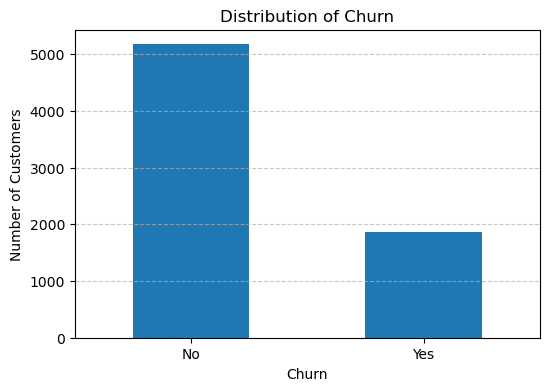


Statistical summaries:
                             mean          std    min      max
Churn                                                         
No    MonthlyCharges    61.265124    31.092648  18.25   118.75
      TotalCharges    2552.882494  2327.590132  18.80  8672.45
      tenure            37.569965    24.113777   0.00    72.00
Yes   MonthlyCharges    74.441332    24.666053  18.85   118.35
      TotalCharges    1531.796094  1890.822994  18.85  8684.80
      tenure            17.979133    19.531123   1.00    72.00


/var/folders/s7/vk2sns2d1_s85y_hl378_rw80000gp/T/ipykernel_91391/1906118668.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


In [97]:
# 1. Exploratory Data Analysis and Preprocessing
df = pd.read_csv('Telco_Customer_Churn.csv')

# 1.1 Load and clean the dataset (handle missing values, outliers, etc.)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Book's preferred imputation

# 1.2 Perform statistical summaries and visualizations to understand patterns 
plt.figure(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Distribution of Churn')
plt.xticks([0,1], ['No', 'Yes'], rotation=0)
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


churn_stats = (
    df.groupby('Churn')[['tenure', 'MonthlyCharges', 'TotalCharges']]
    .describe()
    .stack(level=0) 
    .loc[:, ['mean', 'std', 'min', 'max']]
)
print("\nStatistical summaries:")
print(churn_stats)

# 1.4 Transform categorical variables (one-hot encoding, label encoding)

df['Churn'] = LabelEncoder().fit_transform(df['Churn'])

category_columns = ['gender','Partner','Dependents','PhoneService',
           'MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport',
           'StreamingTV','StreamingMovies','Contract',
           'PaperlessBilling','PaymentMethod']

df = pd.get_dummies(df, columns=category_columns, drop_first=True)  


In [99]:
# 1.5 Split data into training (80%) and testing (20%) sets
X = df.drop(['Churn','customerID'], axis=1)
y = df['Churn']

df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['Churn'] 
)
print('\nTraining set:\n', df_train['Churn'].value_counts())
print()
print('Test set:\n', df_test['Churn'].value_counts())


Training set:
 Churn
0    4139
1    1495
Name: count, dtype: int64

Test set:
 Churn
0    1035
1     374
Name: count, dtype: int64


In [135]:

# 2. Feature Engineering 

# 2.1 Create new features if needed (e.g., tenure groups, monthly spend per service)
df_train['TenureGroup'] = pd.cut(df_train['tenure'],
                               bins=[0, 12, 24, 72],
                               labels=['0-12mo', '13-24mo', '25+mo'])


paid_services = ['PhoneService_Yes', 'InternetService_Fiber optic', 
                'StreamingTV_Yes', 'StreamingMovies_Yes']

df_train['PaidServicesCount'] = df_train[paid_services].sum(axis=1)

df_train['MonthlySpendPerService'] = np.where(
    df_train['PaidServicesCount'] > 0,
    df_train['MonthlyCharges'] / df_train['PaidServicesCount'],
    0  
)

# 2.2 Use correlation analysis and feature importance to select key predictors
corr_with_churn = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("\nTop Correlated Features:")
print(corr_with_churn.head(10)) 



Top Correlated Features:
tenure                                  0.345593
InternetService_Fiber optic             0.312656
PaymentMethod_Electronic check          0.309214
Contract_Two year                       0.302209
StreamingMovies_No internet service     0.228929
TechSupport_No internet service         0.228929
DeviceProtection_No internet service    0.228929
OnlineBackup_No internet service        0.228929
OnlineSecurity_No internet service      0.228929
InternetService_No                      0.228929
dtype: float64


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



+---------------------+------------+-------------+----------+-------+-------+
| Model               |   Accuracy |   Precision |   Recall |    F1 |   AUC |
+=====================+============+=============+==========+=======+=======+
| Logistic Regression |      0.804 |       0.655 |    0.553 | 0.600 | 0.843 |
+---------------------+------------+-------------+----------+-------+-------+
| Random Forest       |      0.786 |       0.620 |    0.497 | 0.552 | 0.826 |
+---------------------+------------+-------------+----------+-------+-------+
| k-NN                |      0.766 |       0.579 |    0.430 | 0.494 | 0.755 |
+---------------------+------------+-------------+----------+-------+-------+


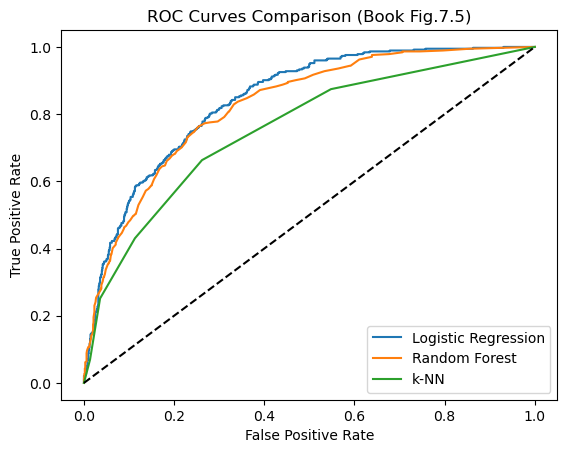


Best Model: Logistic Regression (AUC = 0.843)


In [131]:

# 3. Model Building & Evaluation 
# three of the methods from this course,
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "k-NN": KNeighborsClassifier()
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name}')

headers = ["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
print("\n" + tabulate(results, headers=headers, floatfmt=".3f", tablefmt="grid"))

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Book Fig.7.5)')
plt.legend()
plt.show()

# Select best model by AUC 
best_model_info = max(results, key=lambda x: x[5]) 
print(f"\nBest Model: {best_model_info[0]} (AUC = {best_model_info[5]:.3f})")